# Task Reduction

## Process Overview
 
## Initial Data Splitting:
The dataset was first split into two subsets: one for ranking the tasks and another for evaluating the final ensemble model.
 
## Task Ranking:
- For each task, a ***Random Forest*** classifier was trained using the ranking subset (derived from a second split).
- The tasks were ranked based on their F1 scores on a validation set derived from this second split.
 
## Retraining and Ensemble Evaluation:
- After ranking the tasks, we retrained the models on the entire training dataset (excluding the final test set).
- We created subsets of tasks, starting with the highest-ranked ones and progressively adding tasks in order of their ranking.
- For each subset, a new ensemble model was evaluated using the majority voting strategy on the isolated test set.

               Accuracy  Precision    Recall        F1  Sensitivity  \
Ensemble_Size                                                         
1              0.734000   0.719229  0.771176  0.737266     0.771176   
2              0.734000   0.719229  0.771176  0.737266     0.771176   
3              0.791143   0.770760  0.829412  0.795205     0.829412   
4              0.791143   0.770760  0.829412  0.795205     0.829412   
5              0.810571   0.787249  0.854706  0.815468     0.854706   
6              0.810571   0.787249  0.854706  0.815468     0.854706   
7              0.819143   0.790697  0.869412  0.824385     0.869412   
8              0.819143   0.790697  0.869412  0.824385     0.869412   
9              0.829143   0.798981  0.879412  0.833716     0.879412   
10             0.829143   0.798981  0.879412  0.833716     0.879412   
11             0.826571   0.795305  0.878824  0.831719     0.878824   
12             0.826571   0.795305  0.878824  0.831719     0.878824   
13    

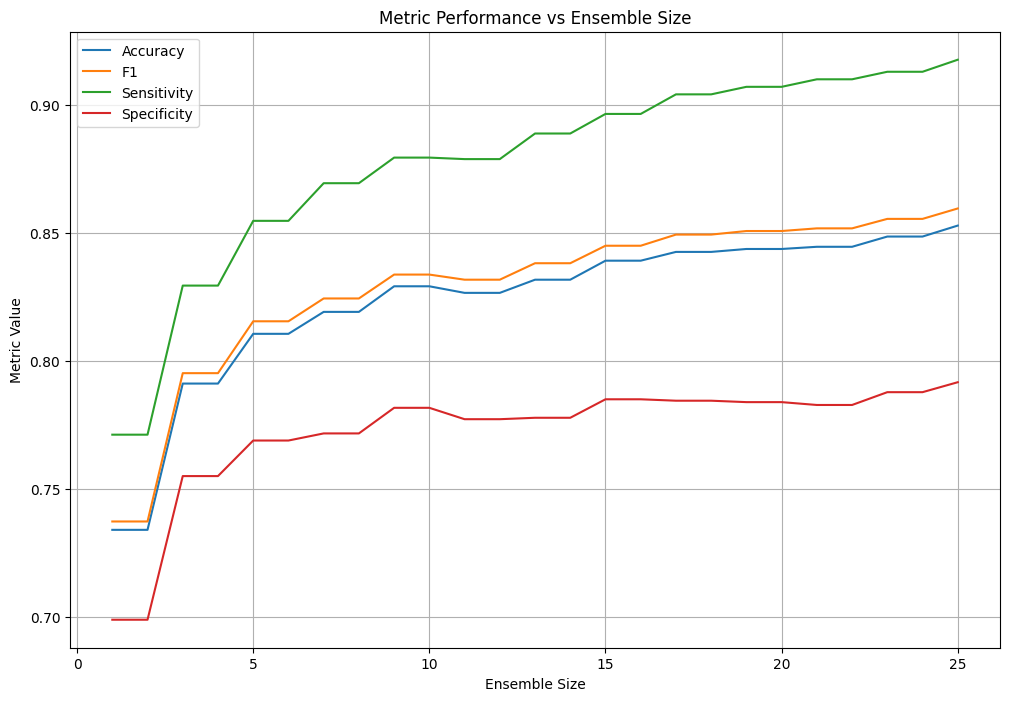

In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score
from ucimlrepo import fetch_ucirepo
import matplotlib.pyplot as plt
 
# Fetch dataset
darwin = fetch_ucirepo(id=732)
 
# Data (as pandas dataframes)
X = darwin.data.features
y = darwin.data.targets
 
# Drop the 'ID' column if it exists
if 'ID' in X.columns:
    X = X.drop(columns=['ID'])
 
# Ensure y is a Series
if isinstance(y, pd.DataFrame):
    y = y.iloc[:, 0]
 
# Number of attributes per task and number of tasks
num_attributes_per_task = 18
num_tasks = 25
 
# Define the number of runs
n_runs = 100
 
# Convert class labels to integers for processing
class_mapping = {label: idx for idx, label in enumerate(y.unique())}
reverse_class_mapping = {idx: label for label, idx in class_mapping.items()}
 
# Random Forest parameters
rf_params = {
    'bootstrap': True,
    'criterion': 'gini',
    'max_depth': 2,
    'min_samples_leaf': 1,
    'min_samples_split': 2,
    'n_estimators': 50
}
 
def evaluate_ensemble(task_predictions, y_test, class_mapping):
    def majority_voting(predictions):
        """Perform majority voting with tie-breaking."""
        unique, counts = np.unique(predictions, return_counts=True)
        count_dict = dict(zip(unique, counts))
        # Find the maximum count
        max_count = max(counts)
        # Identify the classes with the maximum count
        max_classes = [cls for cls, count in count_dict.items() if count == max_count]
        if len(max_classes) == 1:
            return max_classes[0]
        else:
            return None  # Tie case
 
    # Majority voting with tie-breaking
    final_predictions_int = []
    for i in range(task_predictions.shape[1]):
        pred_for_instance = task_predictions[:, i]
        final_prediction = majority_voting(pred_for_instance)
        if final_prediction is None:
            # Handle tie-breaking by excluding the most recent task's vote
            for k in range(task_predictions.shape[0] - 1, -1, -1):
                reduced_predictions = np.delete(pred_for_instance, k)
                final_prediction = majority_voting(reduced_predictions)
                if final_prediction is not None:
                    break
        final_predictions_int.append(final_prediction)
    final_predictions = np.array([reverse_class_mapping[pred] for pred in final_predictions_int])
    # Calculate metrics
    accuracy = accuracy_score(y_test, final_predictions)
    precision = precision_score(y_test, final_predictions, pos_label=list(class_mapping.keys())[1])
    recall = recall_score(y_test, final_predictions, pos_label=list(class_mapping.keys())[1])
    f1 = f1_score(y_test, final_predictions, pos_label=list(class_mapping.keys())[1])
    # Compute confusion matrix
    cm = confusion_matrix(y_test, final_predictions, labels=list(class_mapping.keys()))
    TP, FN, FP, TN = cm[1, 1], cm[1, 0], cm[0, 1], cm[0, 0]
    sensitivity = TP / (TP + FN) if (TP + FN) > 0 else 0
    specificity = TN / (TN + FP) if (TN + FP) > 0 else 0
    return accuracy, precision, recall, f1, sensitivity, specificity
 
# Initialize lists to store the metrics for each ensemble size
ensemble_metrics = []
 
for run in range(n_runs):
    # Step 1: Shuffle and split the data
    X_to_split, X_ensemble_test, y_to_split, y_ensemble_test = train_test_split(X, y, test_size=0.2, random_state=None, stratify=y)
    # Step 2: Split the remaining data for task ranking
    X_to_rank, X_test, y_to_rank, y_test = train_test_split(X_to_split, y_to_split, test_size=0.2, random_state=None, stratify=y_to_split)
    # Initialize lists to store the metrics for each ensemble size
    task_predictions = []
    task_f1_scores = []
 
    # Train a Random Forest classifier for each task and rank them
    for i in range(num_tasks):
        # Get feature columns for the current task
        start_index = i * num_attributes_per_task
        end_index = start_index + num_attributes_per_task
        task_columns = X_to_rank.columns[start_index:end_index]
 
        # Train the Random Forest classifier
        clf = RandomForestClassifier(**rf_params, random_state=None)
        clf.fit(X_to_rank[task_columns], y_to_rank)
 
        # Predict on the test set for ranking
        task_pred = clf.predict(X_test[task_columns])
        task_pred_int = np.array([class_mapping[pred] for pred in task_pred])
        # Calculate F1 score for this task
        task_f1 = f1_score(y_test, task_pred, pos_label=list(class_mapping.keys())[1])
        task_f1_scores.append(task_f1)
        task_predictions.append(task_pred_int)
 
    # Sort tasks by F1 score
    sorted_task_indices = np.argsort(task_f1_scores)[::-1]
 
    # Step 3: Re-train on the full training set and evaluate on the ensemble test set
    task_predictions_ensemble = []
    for i in range(num_tasks):
        # Get feature columns for the current task
        start_index = i * num_attributes_per_task
        end_index = start_index + num_attributes_per_task
        task_columns = X_to_split.columns[start_index:end_index]
 
        # Train the Random Forest classifier on full training set
        clf = RandomForestClassifier(**rf_params, random_state=None)
        clf.fit(X_to_split[task_columns], y_to_split)
 
        # Predict on the ensemble test set
        task_pred = clf.predict(X_ensemble_test[task_columns])
        task_pred_int = np.array([class_mapping[pred] for pred in task_pred])
 
        task_predictions_ensemble.append(task_pred_int)
 
    # Convert task_predictions_ensemble to a numpy array
    task_predictions_ensemble = np.array(task_predictions_ensemble)
 
    # Evaluate ensembles of increasing size
    for k in range(1, num_tasks + 1):
        top_k_tasks = sorted_task_indices[:k]
        top_k_predictions = task_predictions_ensemble[top_k_tasks]
        # Evaluate the ensemble
        metrics = evaluate_ensemble(top_k_predictions, y_ensemble_test, class_mapping)
        ensemble_metrics.append((k, *metrics))
 
# Convert results to DataFrame for easier analysis
results_df = pd.DataFrame(ensemble_metrics, columns=['Ensemble_Size', 'Accuracy', 'Precision', 'Recall', 'F1', 'Sensitivity', 'Specificity'])
 
# Group by ensemble size and calculate mean metrics across runs
mean_results = results_df.groupby('Ensemble_Size').mean()
 
# Print results
print(mean_results)
 
# Find the best ensemble size based on F1 score
best_size = mean_results['F1'].idxmax()
print(f"\nBest ensemble size based on F1 score: {best_size}")
print("Metrics for the best ensemble size:")
print(mean_results.loc[best_size])
 
# Plotting
plt.figure(figsize=(12, 8))
for metric in ['Accuracy', 'F1', 'Sensitivity', 'Specificity']:
    plt.plot(mean_results.index, mean_results[metric], label=metric)
plt.xlabel('Ensemble Size')
plt.ylabel('Metric Value')
plt.title('Metric Performance vs Ensemble Size')
plt.legend()
plt.grid(True)
 
# Save the plot as a PNG image in the same directory
plt.savefig('RandomForest_task-reduction_100.png', format='png')
 
# Show the plot
plt.show()